In [67]:
import numpy as np
from scipy.stats import norm

def black_scholes(S, K, T, r, sigma, option_type="call"):
    # Calcul de d1 et d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    # Calcul du prix selon le type d'option
    if option_type == "call":
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")
    
    return price

# Exemple d'utilisation
S = 100  # Prix de l'actif
K = 110  # Prix d'exercice
T = 1    # Temps jusqu'à l'échéance (en années)
r = 0.05 # Taux sans risque (5%)
sigma = 0.2  # Volatilité (20%)

call_price = black_scholes(S, K, T, r, sigma, option_type="call")
put_price = black_scholes(S, K, T, r, sigma, option_type="put")

print(f"Prix de l'option Call: {call_price:.2f}")
print(f"Prix de l'option Put: {put_price:.2f}")


Prix de l'option Call: 6.04
Prix de l'option Put: 10.68


In [68]:
def calcul_volatilite_historique(prix, periode=252):
    rendements = np.log(prix[1:] / prix[:-1])  # Rendements logarithmiques
    volatilite = np.std(rendements) * np.sqrt(periode)  # Annualisation
    return volatilite

# Exemple
prix_historique = [100, 102, 101, 103, 104, 106, 105]  # Prix journaliers
vol_historique = calcul_volatilite_historique(np.array(prix_historique))
print(f"Volatilité historique : {vol_historique:.2%}")


Volatilité historique : 20.73%


In [69]:
from scipy.optimize import brentq

def volatilite_implicite(prix_marche, S, K, T, r, option_type="call"):
    def equation_volatilite(sigma):
        prix_modele = black_scholes(S, K, T, r, sigma, option_type)
        return prix_modele - prix_marche #spot

    #  Résolution entre une volatilité minimale (1e-5) et maximale (1)
    sigma_implicite = brentq(equation_volatilite, 1e-5, 1) #cherche le sigma tel que prix_modele- prix_mache =0
    return sigma_implicite

# Exemple
prix_option_marche = 10  # Prix observé sur le marché
sigma_implicite = volatilite_implicite(prix_option_marche, S=100, K=110, T=1, r=0.05, option_type="call")
print(f"Volatilité implicite : {sigma_implicite:.2%}")

Volatilité implicite : 29.95%


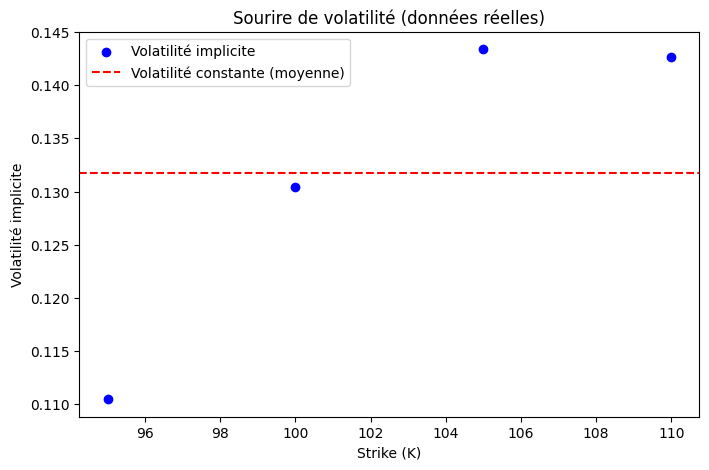

In [70]:
import pandas as pd
from scipy.optimize import brentq
import matplotlib.pyplot as plt
# Calcul de la volatilité implicite
def volatilite_implicite(S, K, T, r, prix_observe, option_type="call"):
    def equation_vol(sigma):
        return black_scholes(S, K, T, r, sigma, option_type) - prix_observe
    try:
        return brentq(equation_vol, 1e-4, 5)
    except ValueError:
        return np.nan  # Retourne NaN si l'équation n'a pas de solution

# Chargement des données
data = pd.read_csv("/kaggle/input/options-data-csv/options_data.csv")
S0 = 100  # Exemple de prix du sous-jacent
r = 0.05  # Taux sans risque
T = 0.5   # Temps à maturité en années

# Calcul des volatilités implicites
data["vol_implicite"] = data.apply(
    lambda row: volatilite_implicite(S0, row["strike"], T, r, row["price"], row["type"]), #attention a lordre
    axis=1
)

# Tracé du sourire de volatilité
plt.figure(figsize=(8, 5))
plt.scatter(data["strike"], data["vol_implicite"], label="Volatilité implicite", color="blue")
plt.axhline(y=data["vol_implicite"].mean(), color="red", linestyle="--", label="Volatilité constante (moyenne)")
plt.xlabel("Strike (K)")
plt.ylabel("Volatilité implicite")
plt.title("Sourire de volatilité (données réelles)")
plt.legend()
plt.show()

## Avec de vraies données

In [ ]:
df.columns

In [71]:
df = pd.read_csv("/kaggle/input/appleoption/aapl_2016_2020.csv")
df.columns = df.columns.str.strip() #pour enlever les espaces problématiques dans les noms de colonnes

# on a des types objets dans le csv
numeric_cols = ["[C_BID]", "[C_ASK]", "[DTE]", "[STRIKE]", "[UNDERLYING_LAST]", "[C_VOLUME]"]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")


<ipython-input-71-91e73a11d958>:1: DtypeWarning: Columns (8,9,10,11,12,15,17,18,20,21,23,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/kaggle/input/appleoption/aapl_2016_2020.csv")


In [ ]:
print(df.columns)


In [72]:
# 3) Calculer T (= [DTE]/365) et C_mid_price pour TOUTES les lignes
df["[T]"] = df["[DTE]"] / 365.0
df["[C_mid_price]"] = 0.5 * (df["[C_BID]"] + df["[C_ASK]"])

r = 0.01  # Taux sans risque (1%)

# 4) Appliquer la fonction sur tout le DataFrame
def compute_call_iv(row):
    S = row["[UNDERLYING_LAST]"]
    K = row["[STRIKE]"]
    T = row["[T]"]
    prix_obs = row["[C_mid_price]"]
    return volatilite_implicite(S, K, T, r, prix_obs, option_type="call")

#df["[C_IV_calc]"] = df.apply(compute_call_iv, axis=1)

df_sample = df.sample(n=1000, random_state=42)  # Prendre 1000 options au hasard
df_sample["[C_IV_calc]"] = np.nan
df_sample["[C_IV_calc]"] = df_sample.apply(compute_call_iv, axis=1)

<ipython-input-67-eea76cf43339>:6: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


In [ ]:
print(df_sample.columns)

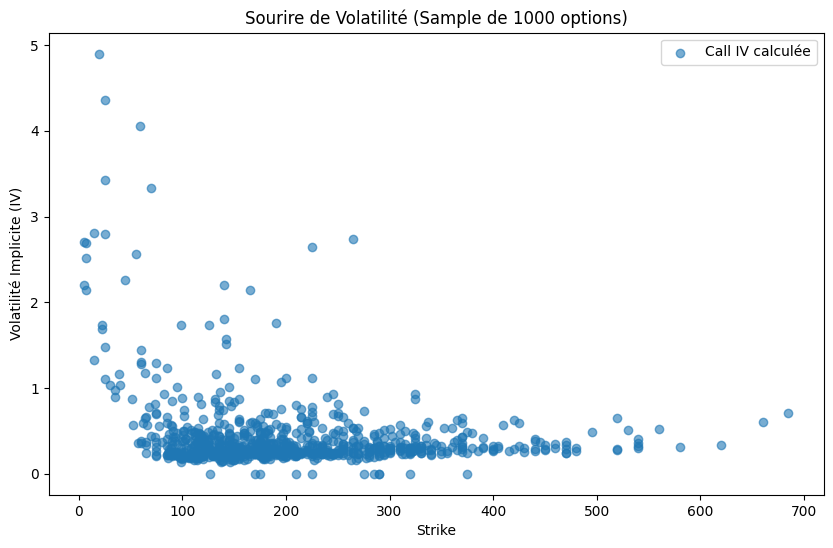

In [73]:
# Tracer le sourire de volatilité
plt.figure(figsize=(10, 6))
plt.scatter(df_sample["[STRIKE]"], df_sample["[C_IV_calc]"], label="Call IV calculée", alpha=0.6)
plt.xlabel("Strike")
plt.ylabel("Volatilité Implicite (IV)")
plt.title("Sourire de Volatilité (Sample de 1000 options)")
plt.legend()
plt.show()